# Air Quality Time Series Prediction using LSTM

This notebook implements a complete pipeline for air quality time series prediction using LSTM neural networks. It includes data preprocessing, model training, evaluation, visualization, and backtesting.

## 1. Import Required Libraries

In [6]:
from ucimlrepo import fetch_ucirepo
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

## 2. Fetch Dataset

In [7]:
# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# 如果targets為None，使用最後一列作為目標
if y is None:
    print("No predefined targets found. Using the last column of features as target.")
    y = X.iloc[:, -1:]  # 最後一列作為目標
    X = X.iloc[:, :-1]  # 移除最後一列從特徵

print("Dataset loaded successfully.")
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")

No predefined targets found. Using the last column of features as target.
Dataset loaded successfully.
Features shape: (9357, 14)
Targets shape: (9357, 1)


## 3. Data Preprocessing

In [8]:
def preprocess_data(X, y):
    # 合併特徵與目標
    data = pd.concat([X, y], axis=1)

    # 建立時間索引：合併 Date 和 Time
    data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
    nan_count = data['DateTime'].isna().sum()
    nan_ratio = nan_count / len(data)
    print(f"DateTime NaN count: {nan_count}, ratio: {nan_ratio:.2%}")
    # 如果DateTime有NaN太多，用linear插值；否則用time插值
    if nan_ratio > 0.1:  # 如果NaN > 10%，用linear
        print("Too many NaN in DateTime, using linear interpolation")
        interp_method = 'linear'
        data = data.drop(columns=['DateTime'])  # 不設索引
    else:
        data = data.dropna(subset=['DateTime'])
        data = data.set_index('DateTime').sort_index()
        interp_method = 'time'

    # 選擇數值特徵（排除 Date 和 Time）
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data_numeric = data[numeric_cols]

    # 用插值處理缺失值
    data_numeric = data_numeric.interpolate(method=interp_method)

    # 用 Z-Score 找出異常點（絕對值 > 3）
    z_scores = np.abs((data_numeric - data_numeric.mean()) / data_numeric.std())
    outliers = z_scores > 3
    data_numeric[outliers] = np.nan

    # 再用插值處理異常點
    data_numeric = data_numeric.interpolate(method=interp_method)

    # 正規化
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_numeric)

    return data_scaled, scaler

## 4. Define Dataset and Model Classes

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=24, target_col=-1):
        self.data = data
        self.seq_length = seq_length
        self.target_col = target_col

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :-1]  # 特徵
        y = self.data[idx + self.seq_length, self.target_col]  # 目標（最後一欄）
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [10]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.cat(losses, dim=1).mean()
        return loss

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## 5. Model Training and Evaluation

In [12]:
# 數據前處理
data_scaled, scaler = preprocess_data(X, y)

DateTime NaN count: 9357, ratio: 100.00%
Too many NaN in DateTime, using linear interpolation


In [13]:
# 建立資料集
seq_length = 24  # window size
forecast_horizon = 1  # 預測下一個時間點
step_size = 1  # 步長
dataset = TimeSeriesDataset(data_scaled, seq_length=seq_length)

# 數據分割：70% 訓練，15% 驗證，15% 測試
total_len = len(dataset)
train_end = int(0.7 * total_len)
val_end = int(0.85 * total_len)  # 70% + 15%

train_dataset = torch.utils.data.Subset(dataset, range(0, train_end))
val_dataset = torch.utils.data.Subset(dataset, range(train_end, val_end))
test_dataset = torch.utils.data.Subset(dataset, range(val_end, total_len))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# 建立模型、損失函數和優化器
input_size = data_scaled.shape[1] - 1  # 特徵數量
model = LSTMModel(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練參數
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(12, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
# 訓練迴圈
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 驗證
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y)
            val_loss += loss.item()

    val_loss_avg = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss_avg:.4f}")

    # 保存最佳模型
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved at epoch {epoch+1}")

Epoch 1/10, Train Loss: 0.2010, Val Loss: 0.0625
Best model saved at epoch 1
Epoch 2/10, Train Loss: 0.0703, Val Loss: 0.0326
Best model saved at epoch 2
Epoch 2/10, Train Loss: 0.0703, Val Loss: 0.0326
Best model saved at epoch 2
Epoch 3/10, Train Loss: 0.0527, Val Loss: 0.0347
Epoch 3/10, Train Loss: 0.0527, Val Loss: 0.0347
Epoch 4/10, Train Loss: 0.0433, Val Loss: 0.0171
Best model saved at epoch 4
Epoch 4/10, Train Loss: 0.0433, Val Loss: 0.0171
Best model saved at epoch 4
Epoch 5/10, Train Loss: 0.0389, Val Loss: 0.0164
Best model saved at epoch 5
Epoch 5/10, Train Loss: 0.0389, Val Loss: 0.0164
Best model saved at epoch 5
Epoch 6/10, Train Loss: 0.0363, Val Loss: 0.0156
Best model saved at epoch 6
Epoch 6/10, Train Loss: 0.0363, Val Loss: 0.0156
Best model saved at epoch 6
Epoch 7/10, Train Loss: 0.0331, Val Loss: 0.0140
Best model saved at epoch 7
Epoch 7/10, Train Loss: 0.0331, Val Loss: 0.0140
Best model saved at epoch 7
Epoch 8/10, Train Loss: 0.0324, Val Loss: 0.0149
Epoch 

In [16]:
# 測試最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        test_loss += loss.item()
        all_preds.extend(output.squeeze().cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

test_loss_avg = test_loss / len(test_loader)
mae = mean_absolute_error(all_targets, all_preds)
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
r2 = r2_score(all_targets, all_preds)

print(f"Test Loss (MSE): {test_loss_avg:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

Test Loss (MSE): 0.0106
Test MAE: 0.0734
Test RMSE: 0.1024
Test R²: 0.9765


## 6. Visualization

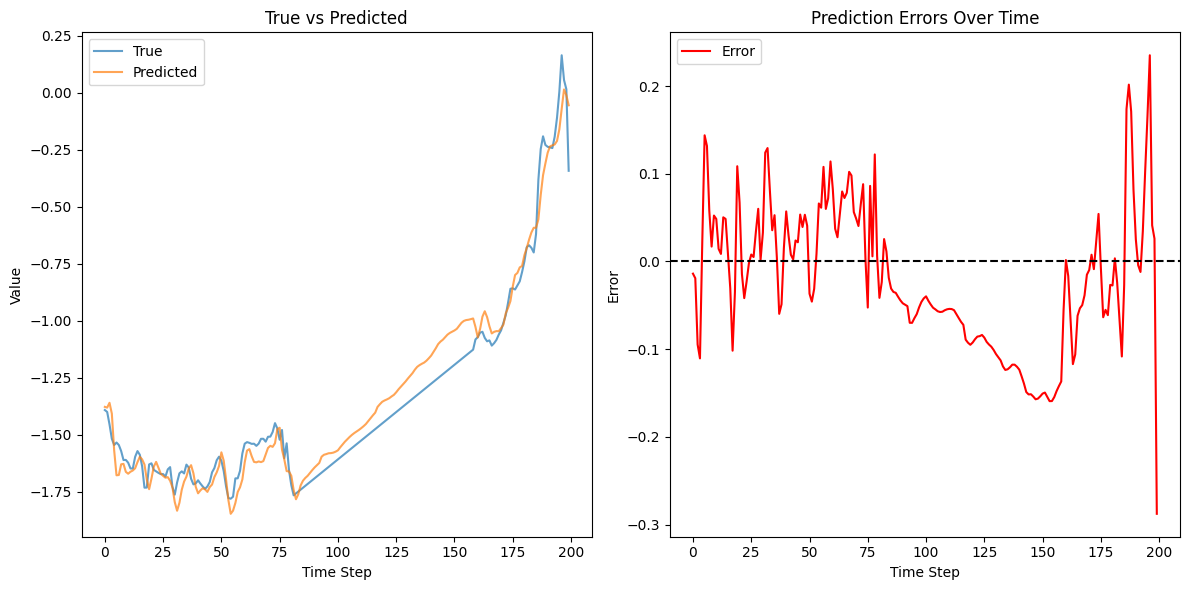

In [17]:
# 視覺化：實測 vs 預測 曲線
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(all_targets[:200], label='True', alpha=0.7)  # 只畫前200點
plt.plot(all_preds[:200], label='Predicted', alpha=0.7)
plt.title('True vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# 誤差時間趨勢圖
errors = np.array(all_targets) - np.array(all_preds)
plt.subplot(1, 2, 2)
plt.plot(errors[:200], label='Error', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Prediction Errors Over Time')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.savefig('evaluation_plots.png')
plt.show()

## 7. Backtesting

In [18]:
def backtesting(data, seq_length=24, train_ratio=0.7, step=1):
    """
    回測：滾動預測，檢視模型穩定性
    """
    n = len(data)
    train_size = int(n * train_ratio)
    predictions = []
    actuals = []

    for i in range(train_size, n - seq_length, step):
        # 訓練數據：0到i
        train_data = data[:i]
        if len(train_data) < seq_length + 10:  # 至少有點數據
            continue

        # 簡單訓練（這裡簡化，用線性模型代替LSTM以節省時間）
        from sklearn.linear_model import LinearRegression
        X_train = []
        y_train = []
        for j in range(len(train_data) - seq_length):
            X_train.append(train_data[j:j+seq_length, :-1].flatten())
            y_train.append(train_data[j+seq_length, -1])
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model = LinearRegression()
        model.fit(X_train, y_train)

        # 預測下一個
        x_pred = data[i:i+seq_length, :-1].flatten().reshape(1, -1)
        pred = model.predict(x_pred)[0]
        actual = data[i+seq_length, -1]

        predictions.append(pred)
        actuals.append(actual)

    # 計算回測指標
    mae_bt = mean_absolute_error(actuals, predictions)
    rmse_bt = np.sqrt(mean_squared_error(actuals, predictions))
    r2_bt = r2_score(actuals, predictions)

    print("\nBacktesting Results:")
    print(f"MAE: {mae_bt:.4f}")
    print(f"RMSE: {rmse_bt:.4f}")
    print(f"R²: {r2_bt:.4f}")

    # 畫回測圖
    plt.figure(figsize=(10, 5))
    plt.plot(actuals[:100], label='Actual', alpha=0.7)
    plt.plot(predictions[:100], label='Predicted', alpha=0.7)
    plt.title('Backtesting: Rolling Predictions')
    plt.xlabel('Prediction Step')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig('backtesting_plot.png')
    plt.show()

    return predictions, actuals


Backtesting Results:
MAE: 0.2849
RMSE: 0.3463
R²: 0.6872


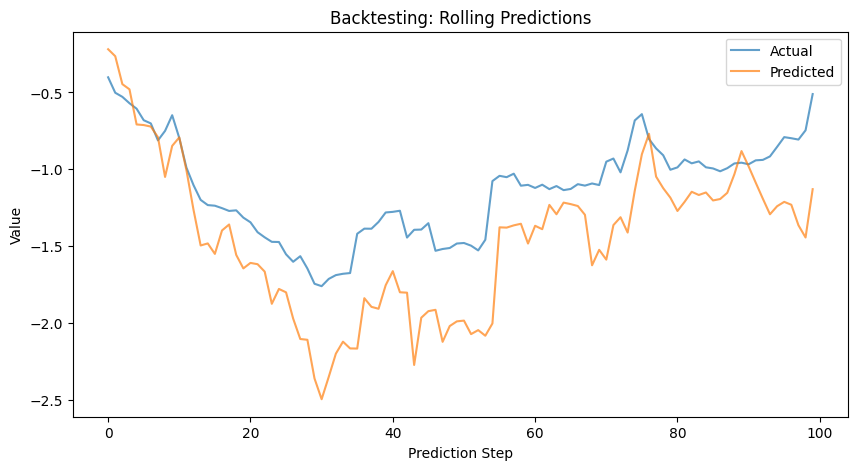

([-0.21929409835746116,
  -0.26474764420906904,
  -0.4462999842404627,
  -0.4800454891968666,
  -0.7083369101955383,
  -0.7122839223432753,
  -0.7221469239983158,
  -0.7912217564526844,
  -1.0496493981991235,
  -0.8477067642816241,
  -0.7923159006161782,
  -1.00521496612401,
  -1.2636837970815809,
  -1.4951451927454125,
  -1.481727014548959,
  -1.5498207747515744,
  -1.3976467796567724,
  -1.3587215704844735,
  -1.5564957905176833,
  -1.644230230936801,
  -1.608482268602299,
  -1.6169128947109832,
  -1.6651040694509023,
  -1.874410645721849,
  -1.7777483098963542,
  -1.7997178180730642,
  -1.9704767793007447,
  -2.103150433169902,
  -2.108319226552664,
  -2.3597086121947974,
  -2.494638563057261,
  -2.349257198909135,
  -2.198468854469209,
  -2.120452582415795,
  -2.1643864485242847,
  -2.1652489762550764,
  -1.837831466940161,
  -1.8940763304577484,
  -1.9066041023077247,
  -1.7535899166430404,
  -1.6620624009319522,
  -1.7993558788039024,
  -1.8019637585795973,
  -2.2719344919656197,

In [20]:
# 運行回測
backtesting(data_scaled)